In [1]:
import torch
import matplotlib.pyplot as plt
import torch.distributions as dist
import copy
from functools import partial
# Matplotlib retina
%config InlineBackend.figure_format = 'retina'

from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import pandas as pd
import numpy as np

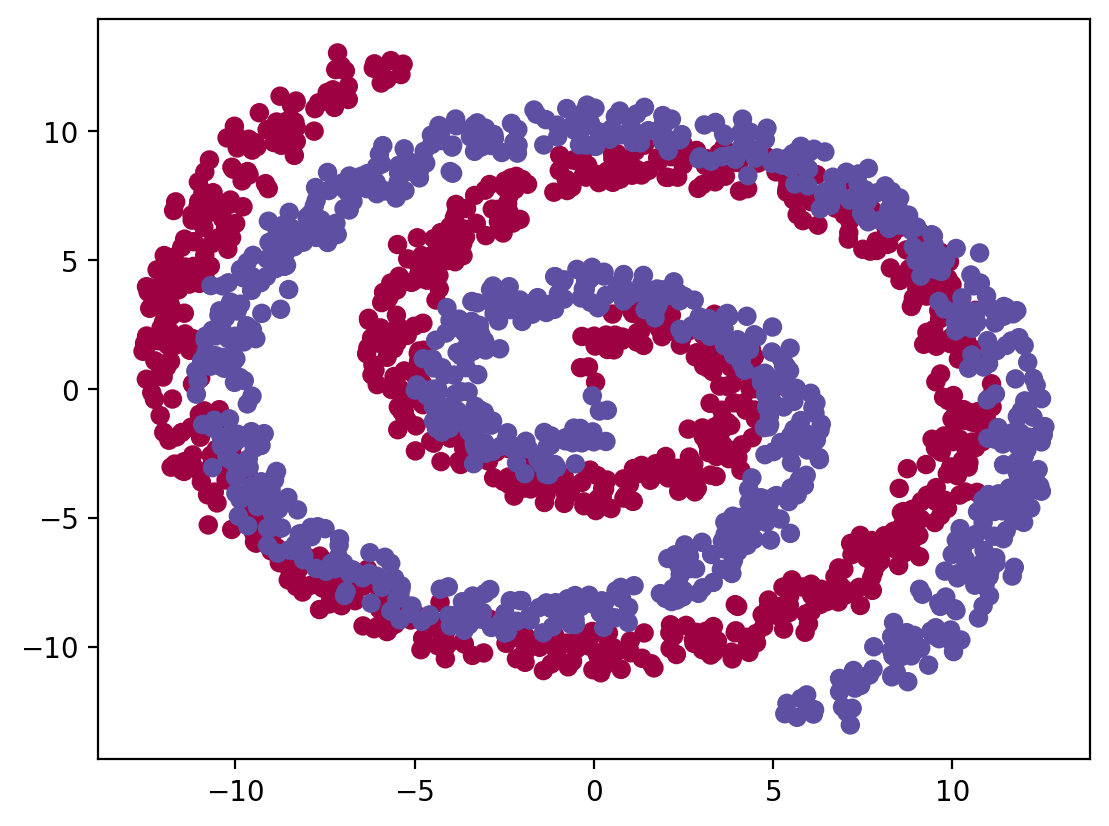

In [2]:
# From: https://glowingpython.blogspot.com/2017/04/solving-two-spirals-problem-with-keras.html
def twospirals(n_points, noise=1.7):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)


In [3]:
# Divide the dataset into train, test and validation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)


In [4]:
X_train.shape, X_test.shape, X_val.shape

((1125, 2), (500, 2), (375, 2))

In [5]:
# Move to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)

X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

X_val = torch.tensor(X_val, dtype=torch.float)
y_val = torch.tensor(y_val, dtype=torch.float)


In [6]:
# Create a simple MLP with hyperparameter being the regularization strength

class SimpleMLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
import torch.nn.functional as F
import torch.optim as optim

# Define a function to train and evaluate a model with a given regularization rate
def train_and_evaluate_model(lam):
    model = SimpleMLP(input_dim=2, hidden_dim=80, output_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCEWithLogitsLoss()

    epochs = 500
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train.unsqueeze(1))

        # L2 regularization
        l2_reg = torch.tensor(0.)
        for param in model.parameters():
            l2_reg += torch.norm(param)

        loss += lam * l2_reg

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    with torch.no_grad():
        val_outputs = model(X_val)
        val_preds = torch.round(torch.sigmoid(val_outputs))
        accuracy = accuracy_score(y_val.numpy(), val_preds.numpy())

    return accuracy


In [8]:
# Define a range of regularization rates to try
log_reg_rates = [-6, -5, -4, -3, -2, -1.9, -1.8, -1, 0, 1]
reg_rates = [10**x for x in log_reg_rates]

accuracies= {}

# Train and evaluate models for each regularization rate
for lam in reg_rates:
    accuracy = train_and_evaluate_model(lam)
    accuracies[lam] = accuracy
    print(f'Regularization Rate: {lam}, Validation Accuracy: {accuracy}')

Regularization Rate: 1e-06, Validation Accuracy: 0.8773333333333333
Regularization Rate: 1e-05, Validation Accuracy: 0.8906666666666667
Regularization Rate: 0.0001, Validation Accuracy: 0.896
Regularization Rate: 0.001, Validation Accuracy: 0.8933333333333333
Regularization Rate: 0.01, Validation Accuracy: 0.8933333333333333
Regularization Rate: 0.012589254117941675, Validation Accuracy: 0.896
Regularization Rate: 0.015848931924611134, Validation Accuracy: 0.888
Regularization Rate: 0.1, Validation Accuracy: 0.8666666666666667
Regularization Rate: 1, Validation Accuracy: 0.5093333333333333
Regularization Rate: 10, Validation Accuracy: 0.49066666666666664


<AxesSubplot:>

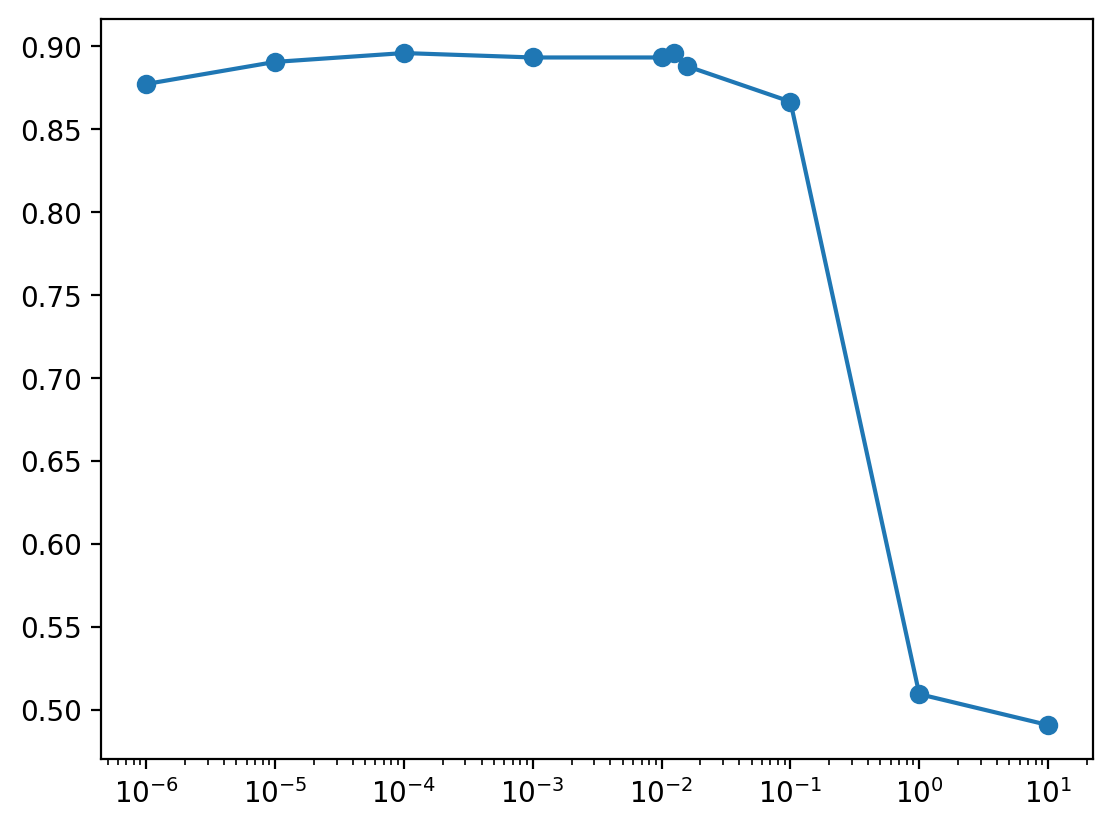

In [10]:
ser = pd.Series(accuracies)
ser.plot(logx=True, style='o-')